Columns: ['R', 'Vobs', 'err', 'Vgas', 'Vdisk', 'Vbulge', 'Sdisk', 'Sbulge']


/var/folders/vr/mzpc67ts67z6kh3k2z4h3yvc0000gn/T/ipykernel_8101/3631713868.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,R,Vobs,err,Vgas,Vdisk,Vbulge,Sdisk,Sbulge
0,0.16,24.5,2.83,0.00,23.21,0.0,1105.79,0.0
1,0.26,35.3,2.46,0.00,35.33,0.0,1006.36,0.0
2,0.36,43.2,1.12,1.92,46.97,0.0,938.26,0.0
3,0.46,52.0,1.25,2.29,56.68,0.0,789.78,0.0
4,0.56,60.9,2.93,2.64,63.77,0.0,624.65,0.0


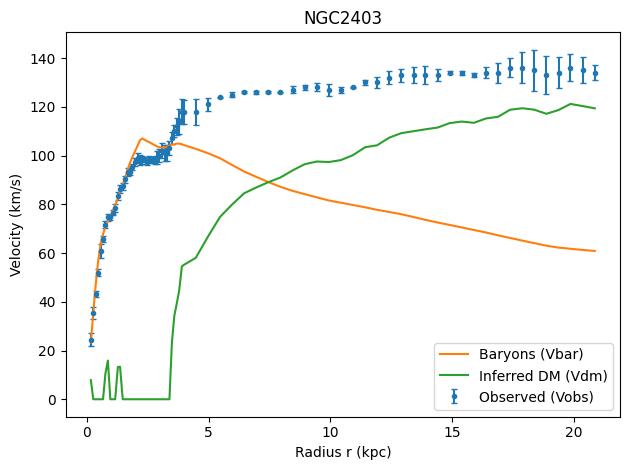

Min/Max radius (kpc): 0.16 20.87
Any negative DM^2 before clipping? True


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1) Point to your data folder ---
PROJECT_ROOT = Path("..")  # notebooks/ is one level down from repo root
SPARC_DIR = PROJECT_ROOT / "data" / "raw" / "sparc_database"

# Pick a galaxy file (change this if you want)
fname = "NGC2403_rotmod.dat"   # try "DDO154_rotmod.dat" if you want a classic DM-dominated dwarf
path = SPARC_DIR / fname

if not path.exists():
    raise FileNotFoundError(f"Can't find: {path}\nCheck the filename and your folder path.")

# --- 2) Load the file ---
# SPARC rotmod files typically have NO header row.
# So we must supply column names manually.
cols = ["R", "Vobs", "err", "Vgas", "Vdisk", "Vbulge", "Sdisk", "Sbulge"]

df = pd.read_csv(
    path,
    delim_whitespace=True,
    comment="#",     # safe even if there are no comment lines
    names=cols       # <-- key fix: prevents first data row becoming header
)

print("Columns:", list(df.columns))
display(df.head())


# --- 3) Identify columns robustly ---
# Common SPARC columns: R, Vobs, e_Vobs (or err), Vgas, Vdisk, Vbul, etc.
# We'll try a few likely names.
def pick_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of these columns found: {candidates}\nAvailable: {list(df.columns)}")

r_col     = pick_col(["R", "r", "Rad", "radius"])
vobs_col  = pick_col(["Vobs", "V_OBS", "V", "Vrot"])
err_col   = None
for cand in ["e_Vobs", "err", "Verr", "eV", "dV", "e_V"]:
    if cand in df.columns:
        err_col = cand
        break

vgas_col  = pick_col(["Vgas", "V_GAS"])
vdisk_col = pick_col(["Vdisk", "V_DISK"])
# Bulge may not exist for many galaxies; default to zeros if missing
vbul_col  = None
for cand in ["Vbul", "Vbulge", "V_BUL", "V_bul"]:
    if cand in df.columns:
        vbul_col = cand
        break

r = df[r_col].to_numpy(dtype=float)
vobs = df[vobs_col].to_numpy(dtype=float)
vgas = df[vgas_col].to_numpy(dtype=float)
vdisk = df[vdisk_col].to_numpy(dtype=float)
vbul = df[vbul_col].to_numpy(dtype=float) if vbul_col is not None else np.zeros_like(r)

e_vobs = df[err_col].to_numpy(dtype=float) if err_col is not None else None

# --- 4) Compute baryonic and inferred dark matter velocities ---
vbar = np.sqrt(np.maximum(vgas**2 + vdisk**2 + vbul**2, 0.0))
vdm2 = np.maximum(vobs**2 - vbar**2, 0.0)
vdm = np.sqrt(vdm2)

# --- 5) Plot ---
plt.figure()
if e_vobs is not None:
    plt.errorbar(r, vobs, yerr=e_vobs, fmt="o", ms=3, capsize=2, label="Observed (Vobs)")
else:
    plt.plot(r, vobs, "o", ms=3, label="Observed (Vobs)")

plt.plot(r, vbar, "-", label="Baryons (Vbar)")
plt.plot(r, vdm, "-", label="Inferred DM (Vdm)")

plt.xlabel("Radius r (kpc)")
plt.ylabel("Velocity (km/s)")
plt.title(fname.replace("_rotmod.dat", ""))
plt.legend()
plt.tight_layout()
plt.show()

# --- 6) Quick sanity prints ---
print("Min/Max radius (kpc):", float(np.min(r)), float(np.max(r)))
print("Any negative DM^2 before clipping?", bool(np.any(vobs**2 - vbar**2 < 0)))
